### Importing libraries

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


import cv2

import skimage
from skimage.transform import resize
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



## Generamos los sets de datos 

Lo primero que se hizo fue difinir el tamaño de las imagenes  se tuvo que modificar ya que debido a que no era posible trabajar con el tamaño normal de 200x200x3 se establecio el tamaño en 64 ya que eran las dimensiones que mejores resultados arrojaban

In [9]:
batch_size = 32
imageSize = 64 # Modificamos el tamño de la imagen ya que no se puede con el tamaño original
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = num_classes*500 #variable que se ajusta segun las imagenes que se quieran usar 

train_dir = '/home/martin/Descargas/señas/archive/asl_alphabet_train/asl_alphabet_train' 
test_dir = '/home/martin/Descargas/señas/archive/asl_alphabet_test'

In [10]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

In [11]:
def data_generation(folder, num):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    i = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            for image_filename in os.listdir(os.path.join(folder, folderName)):#unimos la ruta de las carpetas
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))#recortamos la imagen
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    X[i] = img_arr
                    y[i] = classes.index(folderName)
                    i += 1
                    if i % num == 0:
                        break
        
    return X,y
X_train, y_train = data_generation(train_dir, train_len/num_classes)

/home/martin/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("Image shape : ", X_train[0].shape)

X_train shape :  (14500, 64, 64, 3)
y_train shape :  (14500,)
Image shape :  (64, 64, 3)


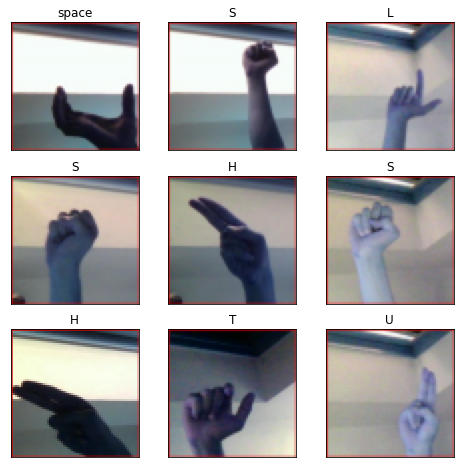

In [13]:
#ploteamos las imagenes
f, axs = plt.subplots(2,2,figsize=(8,8))
for i in range (0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(X_train))
    plt.imshow(X_train[img_nbr])
    plt.title(classes[y_train[img_nbr]])

### Procesamos los datos

In [14]:
# hacemos una copia de los datos
X_data = X_train
y_data = y_train

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,stratify=y_data)

In [16]:
# Tranformamos la salida de one hot encoding
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [17]:
# Dimensiones de nuestros datos 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(y_cat_train.shape)
print(y_cat_test.shape)

(11600, 64, 64, 3)
(11600,)
(2900, 64, 64, 3)
(2900,)
(11600, 29)
(2900, 29)


## Modelo

In [18]:
#Creamos el modelo 
#Despues de varias pruebas este fue el numero de capaz que mejores resultados arrojo
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(imageSize, imageSize, 3)), # Usamos el tamaño de las imagenes
    Activation('relu'), #funcion de activacion relu
    MaxPooling2D((2, 2)), #usamos la funcion de muestro maxpooling con un filtro de 2,2
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
   
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    #Colocamos el dropout
    tf.keras.layers.Dropout(rate=0.3),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(29, activation='softmax') # 29 clases correpondientes a cada uno de los etiquetas que tenemos
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [19]:
# Detenemos el modelo cuando este ya no mejora es decir paramos el numero de epocas
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [20]:
# Definimos el optimizador, la función de perdidas y la métrica
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
#entrenmos
history = model.fit(
    X_train, y_cat_train,
    epochs=50,
    batch_size=32,
    verbose=2,
    validation_data=(X_test, y_cat_test),
    callbacks=[early_stop]
)

Train on 11600 samples, validate on 2900 samples
Epoch 1/50
11600/11600 - 48s - loss: 2.9106 - accuracy: 0.1604 - val_loss: 1.8548 - val_accuracy: 0.4507
Epoch 2/50
11600/11600 - 43s - loss: 1.3478 - accuracy: 0.5694 - val_loss: 0.9978 - val_accuracy: 0.6828
Epoch 3/50
11600/11600 - 40s - loss: 0.7612 - accuracy: 0.7468 - val_loss: 0.5031 - val_accuracy: 0.8421
Epoch 4/50
11600/11600 - 45s - loss: 0.5231 - accuracy: 0.8244 - val_loss: 0.3812 - val_accuracy: 0.8669
Epoch 5/50
11600/11600 - 42s - loss: 0.3796 - accuracy: 0.8716 - val_loss: 0.3775 - val_accuracy: 0.8728
Epoch 6/50
11600/11600 - 43s - loss: 0.3028 - accuracy: 0.8972 - val_loss: 0.2142 - val_accuracy: 0.9286
Epoch 7/50
11600/11600 - 44s - loss: 0.2598 - accuracy: 0.9139 - val_loss: 0.1879 - val_accuracy: 0.9328
Epoch 8/50
11600/11600 - 44s - loss: 0.2211 - accuracy: 0.9226 - val_loss: 0.1619 - val_accuracy: 0.9466
Epoch 9/50
11600/11600 - 42s - loss: 0.1807 - accuracy: 0.9369 - val_loss: 0.1852 - val_accuracy: 0.9383
Epoch 

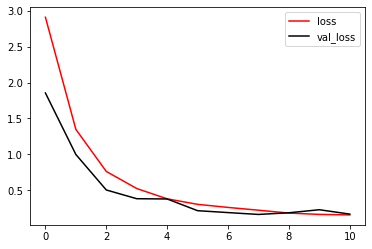

In [33]:
#graficamos la perdida
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(color= ("red","black"))
plt.show()

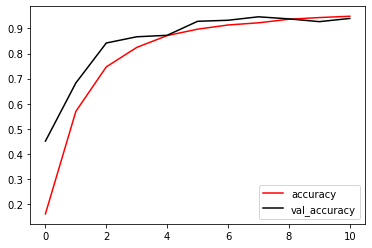

In [32]:
# Vemos que llegan los mejores valores para el conjunto de entrenamiento
history_df.loc[0:, ['accuracy','val_accuracy']].plot(color = ('red',"black"))
plt.show()

## Predictions

In [34]:
# realizamos una prueba de prediccion
predictions = np.argmax(model.predict(X_test), axis=-1)

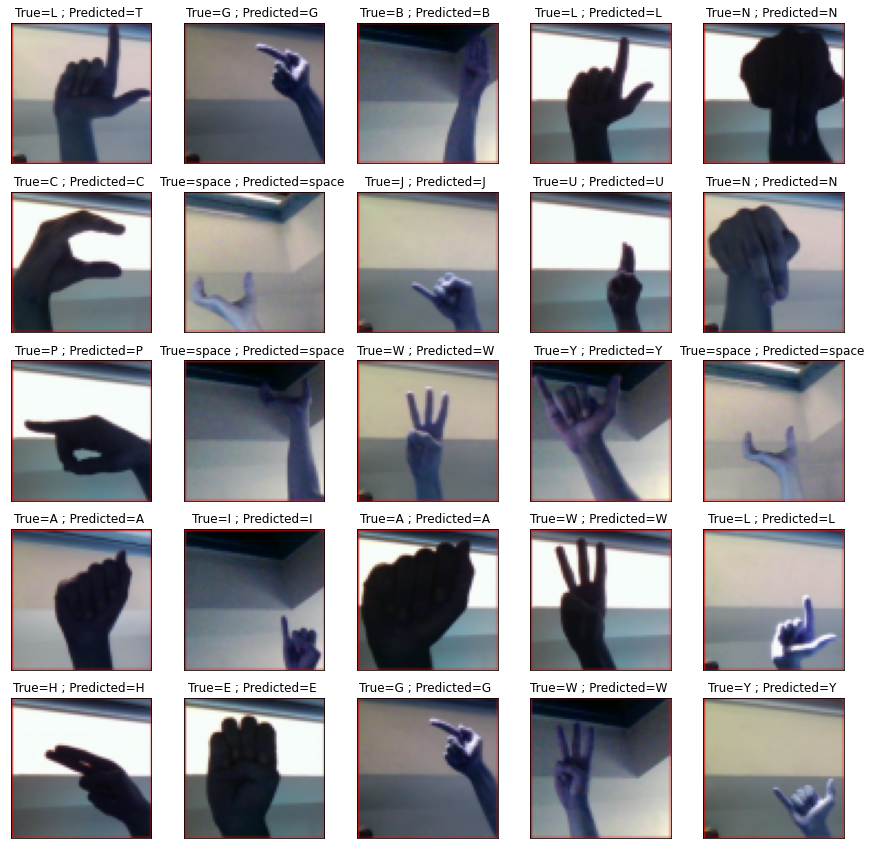

In [35]:
f, axs = plt.subplots(2,2,figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(predictions))
    plt.imshow(X_test[img_nbr])
    plt.title("True={} ; Predicted={} ".format(classes[(y_test[img_nbr])], classes[(predictions[img_nbr])]))

In [37]:
#Podemos ver que clasifica todo de forma bastante correcta

ERROR! Session/line number was not unique in database. History logging moved to new session 38


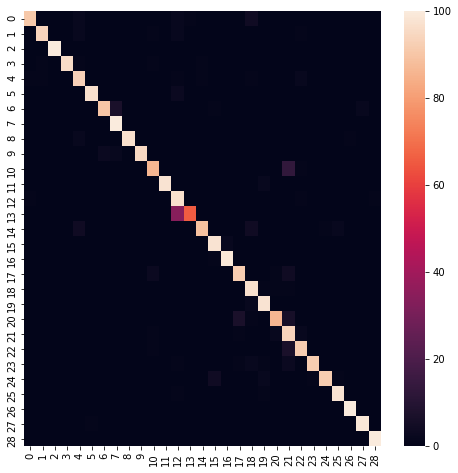

In [36]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()

In [38]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       100
           1       0.98      0.94      0.96       100
           2       1.00      1.00      1.00       100
           3       1.00      0.96      0.98       100
           4       0.89      0.93      0.91       100
           5       0.99      0.97      0.98       100
           6       0.97      0.90      0.93       100
           7       0.92      1.00      0.96       100
           8       1.00      0.97      0.98       100
           9       1.00      0.95      0.97       100
          10       0.92      0.86      0.89       100
          11       1.00      0.98      0.99       100
          12       0.69      0.97      0.80       100
          13       0.99      0.66      0.79       100
          14       0.98      0.89      0.93       100
          15       0.94      0.98      0.96       100
          16       0.98      0.99      0.99       100
          17       0.91    

Despues de intentar con varias combinaciones de parametros en los que se destaca el tamaño de la imagen el numero de capas, la funcion muestral y el numero de capas la combinaciones en este documento fue la que presento los mejores resultados 